<a href="https://colab.research.google.com/github/agarr3/vajra-new/blob/main/AE_HYBRID_LSTM_V6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import IPython.display as ipd

import random

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#settings
batch_size = 64
validation_split = .3
shuffle_dataset = True
random_seed= 42
reduction_loss = "mean"
if reduction_loss == "mean":
  criterion = nn.MSELoss(reduction="mean")
elif reduction_loss == "sum":
  criterion = nn.MSELoss(reduction="sum")
n_epochs = 30
print_every = 1

BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA"

input_bins = 12
seq_len=200
AE_encoded_dim = 64

class_level_loss_mode = "test"

print(device)

cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/songs-vajra-data/"
DATA_SONG_DIR = "Chroma"
DATA_IMG_DIR = "Chroma"



files = []
western_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      western_files.append([file,file, "Western_numpy"])
    else:
      print(file)

random.seed(1234)
western_files = random.sample(western_files, 2008)

indian_files = []
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "Indian_numpy")):
  for file in fileList:
    if(True):
      indian_files.append([file,file, "Indian_numpy"])
    else:
      print(file)

files = indian_files + western_files
dataDF = pd.DataFrame(files, columns=['Images','songs','labels'])
dataDF.head()

098567.npy
098569.npy
098565.npy


,Images,songs,labels
0,Theeyame.npy,Theeyame.npy,Indian_numpy
1,AadedaAattamNee.npy,AadedaAattamNee.npy,Indian_numpy
2,ElampadiElelelo.npy,ElampadiElelelo.npy,Indian_numpy
3,SajanMoreGharAaye.npy,SajanMoreGharAaye.npy,Indian_numpy
4,Aanandhame.npy,Aanandhame.npy,Indian_numpy


In [5]:
if class_level_loss_mode == "all":
  indian_dataDF = pd.DataFrame(indian_files, columns=['Images','songs','labels'])
  indian_dataDF.head()
elif class_level_loss_mode == "test":
  indian_dataDF = dataDF[dataDF['labels'] == "Indian_numpy"]
  indian_dataDF = indian_dataDF.reset_index(drop=True)

In [6]:
if class_level_loss_mode == "all":
  western_dataDF = pd.DataFrame(western_files, columns=['Images','songs','labels'])
  western_dataDF.head()
elif class_level_loss_mode == "test":
  western_dataDF = dataDF[dataDF['labels'] == "Western_numpy"]
  western_dataDF = western_dataDF.reset_index(drop=True)

In [7]:
western_dataDF.groupby("labels").count()

,Images,songs
labels,,
Western_numpy,2008,2008


In [8]:
dataDF.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,2008,2008
Western_numpy,2008,2008


/content/gdrive/My Drive/vajra/songs-vajra-data/Chroma/Indian_numpy/RangeWalaJatt.npy


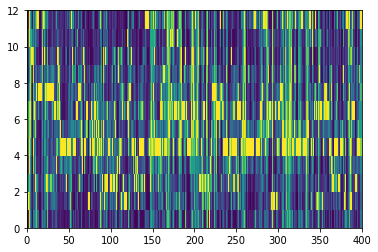

In [9]:
test_idx = random. randint(0,1000)
test_img_path = os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, dataDF.loc[test_idx, 'labels'], dataDF.loc[test_idx, 'Images'])
print(test_img_path)

numpy_arr = np.load(test_img_path)

import matplotlib.pyplot as plt

plt.pcolormesh(numpy_arr)



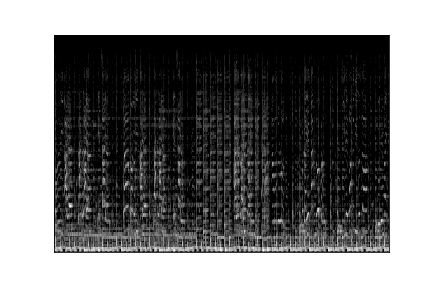

In [10]:
test_img_path = '/content/gdrive/My Drive/Kaggle/GTZAN/Data/images_original/reggae/reggae00016.png'
test_image = Image.open(test_img_path)
test_image = test_image.convert('RGB').convert('L')
test_image

In [11]:
lb = LabelEncoder()
dataDF['encoded_labels'] = lb.fit_transform(dataDF['labels'])
dataDF.head()

,Images,songs,labels,encoded_labels
0,Theeyame.npy,Theeyame.npy,Indian_numpy,0
1,AadedaAattamNee.npy,AadedaAattamNee.npy,Indian_numpy,0
2,ElampadiElelelo.npy,ElampadiElelelo.npy,Indian_numpy,0
3,SajanMoreGharAaye.npy,SajanMoreGharAaye.npy,Indian_numpy,0
4,Aanandhame.npy,Aanandhame.npy,Indian_numpy,0


In [12]:
indian_dataDF['encoded_labels'] = lb.transform(indian_dataDF['labels'])
western_dataDF['encoded_labels'] = lb.transform(western_dataDF['labels'])

In [13]:
indian_dataDF.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,2008,2008


In [14]:
classes = ('Indian_numpy', 'Western_numpy')
dataDF.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,2008,2008
Western_numpy,1,2008,2008


In [15]:
from sklearn.model_selection import train_test_split

dataDF = dataDF.sample(frac=1)
df_train, df_test = train_test_split(dataDF, test_size=validation_split, stratify=dataDF[["labels"]], random_state=9)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


if class_level_loss_mode == "test":
  western_dataDF = df_test[df_test['labels'] == "Western_numpy"]
  western_dataDF = western_dataDF.reset_index(drop=True)
  indian_dataDF = df_test[df_test['labels'] == "Indian_numpy"]
  indian_dataDF = indian_dataDF.reset_index(drop=True)

In [16]:
df_train.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1405,1405
Western_numpy,1,1406,1406


In [17]:
df_test.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,603,603
Western_numpy,1,602,602


In [18]:
indian_dataDF.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,603,603


In [19]:
transform_normal = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor()])

In [20]:
class MEL_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = np.load(img_name)
        data = torch.tensor(image[:,:seq_len], dtype=torch.float)
        data = data.permute(1, 0)
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        fileName = self.img_data.loc[index, 'Images']
        return data, label, fileName



In [21]:
train_dataset = MEL_Dataset(df_train,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
test_dataset = MEL_Dataset(df_test,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)

In [22]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [23]:
indian_dataset = MEL_Dataset(indian_dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
western_dataset = MEL_Dataset(western_dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)

indian_loader = torch.utils.data.DataLoader(indian_dataset, batch_size=batch_size)
western_loader = torch.utils.data.DataLoader(western_dataset, batch_size=batch_size)


In [24]:
len(indian_dataset)

603

In [25]:
def mel_display(S_DB):
    S_DB = S_DB.numpy()
    array = S_DB*-1
    array *= (255.0/array.max())
    #array = 255 - array
    array = np.transpose(array, (2, 1, 0))
    return array.squeeze()

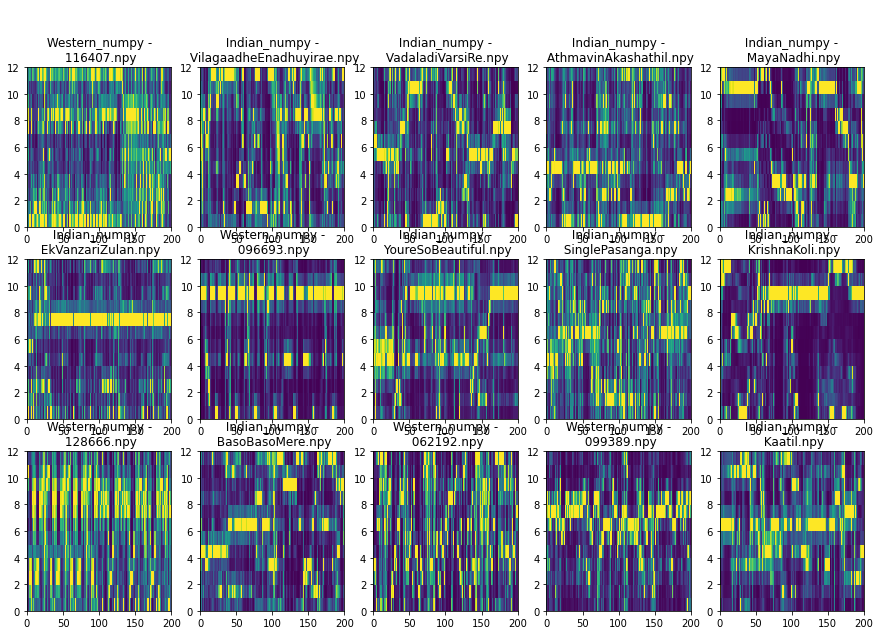

In [26]:
# get some random training images
dataiter = iter(trainloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label, fileName = images[i], labels[i], fileNames[i]
        ax.pcolormesh(image.permute(1, 0)) # add image
        ax.set(title = f"\n \n {arthopod_types[label.item()]} - \n {fileName}") # add label

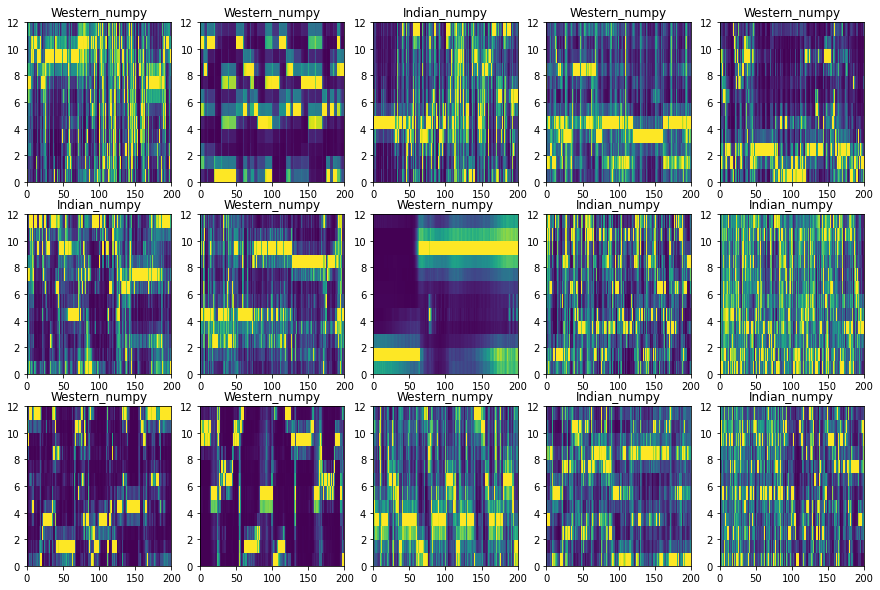

In [27]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.pcolormesh(image.permute(1, 0)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

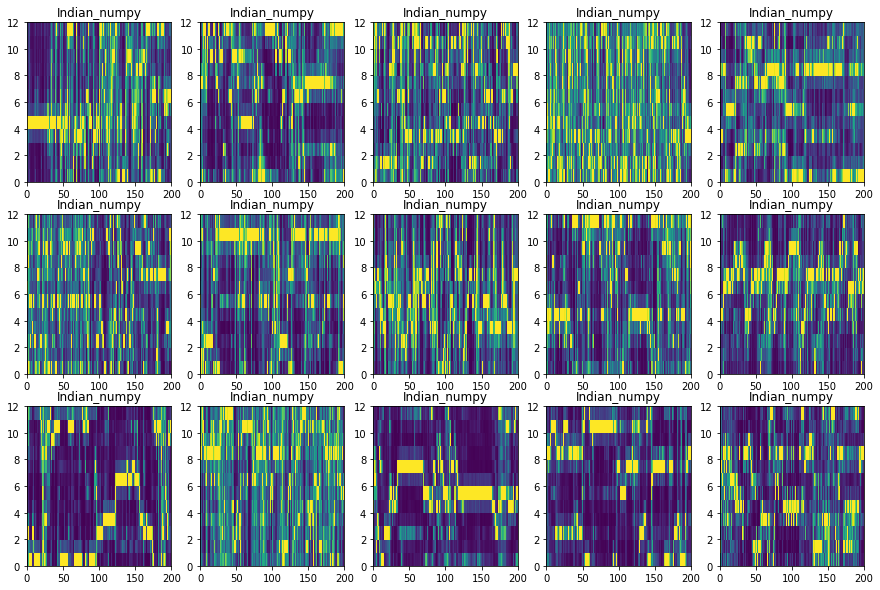

In [28]:
# get some random training images
dataiter = iter(indian_loader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.pcolormesh(image.permute(1, 0)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

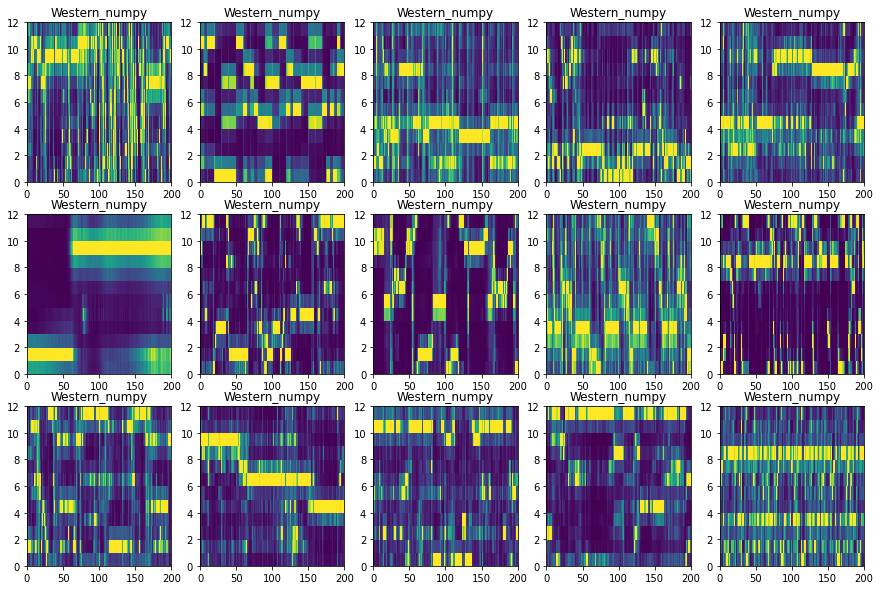

In [29]:
# get some random training images
dataiter = iter(western_loader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.pcolormesh(image.permute(1, 0)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [30]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, kernel_size=[4,3,2], stride=[1,1,1]):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim


    self.conv = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[0],stride=stride[0], groups=seq_len)
    conv_op_dim = int(((n_features - kernel_size[0])/ stride[0]) + 1)

    self.conv_1 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[1],stride=stride[1], groups=seq_len)
    conv_op_dim1 = int(((conv_op_dim - kernel_size[1])/ stride[1]) + 1)

    self.conv_2 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[2],stride=stride[2], groups=seq_len)
    conv_op_dim2 = int(((conv_op_dim1 - kernel_size[2])/ stride[2]) + 1)

    self.rnn1 = nn.LSTM(
      input_size=conv_op_dim2,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = self.conv(x)
    x = self.conv_1(x)
    x = self.conv_2(x)
    lstm_l1_op, (_, _) = self.rnn1(x)
    lstm_l2_op, (hidden_n, _) = self.rnn2(lstm_l1_op)
    return lstm_l2_op, lstm_l1_op

class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=26):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    return x.reshape(x.shape[0],self.seq_len, self.n_features)

class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x, l1_op = self.encoder(x)
    x = self.decoder(x)
    return x

net = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
net.to(device)


RecurrentAutoencoder(
  (encoder): Encoder(
    (conv): Conv1d(200, 200, kernel_size=(4,), stride=(1,), groups=200)
    (conv_1): Conv1d(200, 200, kernel_size=(3,), stride=(1,), groups=200)
    (conv_2): Conv1d(200, 200, kernel_size=(2,), stride=(1,), groups=200)
    (rnn1): LSTM(6, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=25600, out_features=2400, bias=True)
  )
)

In [31]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(train_loss_graph, test_loss_graph):
  x = range(len(train_loss_graph))
      
  # plot lines
  plt.plot(x, train_loss_graph, label = "Training Loss")
  plt.plot(x, test_loss_graph, label = "Test Loss")
  
  plt.legend()
  plt.show()

def visualize_class_loss(in_loss_graph, we_loss_graph):
  x = range(len(in_loss_graph))
      
  # plot lines
  plt.plot(x, in_loss_graph, label = "Indian Loss")
  plt.plot(x, we_loss_graph, label = "Western Loss")
  
  plt.legend()
  plt.show()


[1,     1] loss: 0.123
[1,     2] loss: 0.094
[1,     3] loss: 0.120
[1,     4] loss: 0.146
[1,     5] loss: 0.125
[1,     6] loss: 0.102
[1,     7] loss: 0.095
[1,     8] loss: 0.095
[1,     9] loss: 0.112
[1,    10] loss: 0.119
[1,    11] loss: 0.116
[1,    12] loss: 0.105
[1,    13] loss: 0.094
[1,    14] loss: 0.093
[1,    15] loss: 0.097
[1,    16] loss: 0.103
[1,    17] loss: 0.098
[1,    18] loss: 0.104
[1,    19] loss: 0.098
[1,    20] loss: 0.095
[1,    21] loss: 0.093
[1,    22] loss: 0.095
[1,    23] loss: 0.095
[1,    24] loss: 0.099
[1,    25] loss: 0.096
[1,    26] loss: 0.096
[1,    27] loss: 0.092
[1,    28] loss: 0.095
[1,    29] loss: 0.094
[1,    30] loss: 0.093
[1,    31] loss: 0.093
[1,    32] loss: 0.092
[1,    33] loss: 0.095
[1,    34] loss: 0.094
[1,    35] loss: 0.095
[1,    36] loss: 0.091
[1,    37] loss: 0.094
[1,    38] loss: 0.094
[1,    39] loss: 0.097
[1,    40] loss: 0.096
[1,    41] loss: 0.094
[1,    42] loss: 0.097
[1,    43] loss: 0.094
[1,    44] 

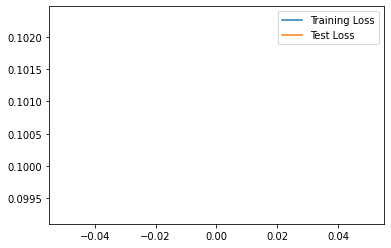

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 0 is 0.10364454984664917
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 0 is 0.10548849900563557


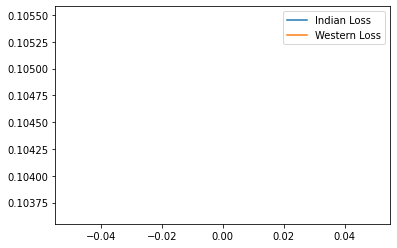

[2,     1] loss: 0.094
[2,     2] loss: 0.094
[2,     3] loss: 0.094
[2,     4] loss: 0.093
[2,     5] loss: 0.095
[2,     6] loss: 0.092
[2,     7] loss: 0.095
[2,     8] loss: 0.092
[2,     9] loss: 0.093
[2,    10] loss: 0.096
[2,    11] loss: 0.096
[2,    12] loss: 0.094
[2,    13] loss: 0.093
[2,    14] loss: 0.093
[2,    15] loss: 0.094
[2,    16] loss: 0.095
[2,    17] loss: 0.093
[2,    18] loss: 0.094
[2,    19] loss: 0.095
[2,    20] loss: 0.094
[2,    21] loss: 0.092
[2,    22] loss: 0.094
[2,    23] loss: 0.094
[2,    24] loss: 0.096
[2,    25] loss: 0.092
[2,    26] loss: 0.096
[2,    27] loss: 0.093
[2,    28] loss: 0.094
[2,    29] loss: 0.094
[2,    30] loss: 0.093
[2,    31] loss: 0.093
[2,    32] loss: 0.093
[2,    33] loss: 0.094
[2,    34] loss: 0.093
[2,    35] loss: 0.095
[2,    36] loss: 0.091
[2,    37] loss: 0.094
[2,    38] loss: 0.094
[2,    39] loss: 0.095
[2,    40] loss: 0.095
[2,    41] loss: 0.094
[2,    42] loss: 0.097
[2,    43] loss: 0.094
[2,    44] 

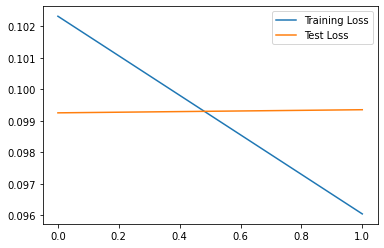

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 1 is 0.10320101016097599
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 1 is 0.106141806476646


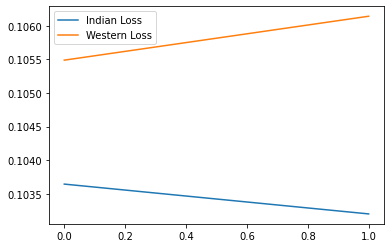

[3,     1] loss: 0.094
[3,     2] loss: 0.095
[3,     3] loss: 0.094
[3,     4] loss: 0.093
[3,     5] loss: 0.095
[3,     6] loss: 0.092
[3,     7] loss: 0.095
[3,     8] loss: 0.092
[3,     9] loss: 0.093
[3,    10] loss: 0.096
[3,    11] loss: 0.096
[3,    12] loss: 0.094
[3,    13] loss: 0.093
[3,    14] loss: 0.093
[3,    15] loss: 0.095
[3,    16] loss: 0.095
[3,    17] loss: 0.094
[3,    18] loss: 0.094
[3,    19] loss: 0.095
[3,    20] loss: 0.094
[3,    21] loss: 0.092
[3,    22] loss: 0.094
[3,    23] loss: 0.094
[3,    24] loss: 0.096
[3,    25] loss: 0.092
[3,    26] loss: 0.096
[3,    27] loss: 0.092
[3,    28] loss: 0.095
[3,    29] loss: 0.094
[3,    30] loss: 0.093
[3,    31] loss: 0.093
[3,    32] loss: 0.093
[3,    33] loss: 0.094
[3,    34] loss: 0.094
[3,    35] loss: 0.095
[3,    36] loss: 0.091
[3,    37] loss: 0.094
[3,    38] loss: 0.094
[3,    39] loss: 0.095
[3,    40] loss: 0.095
[3,    41] loss: 0.094
[3,    42] loss: 0.097
[3,    43] loss: 0.093
[3,    44] 

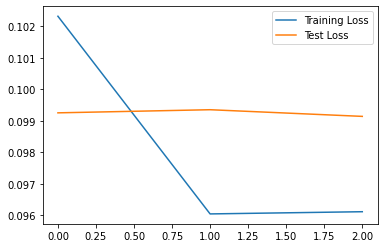

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 2 is 0.1030227384633488
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 2 is 0.10587270143959257


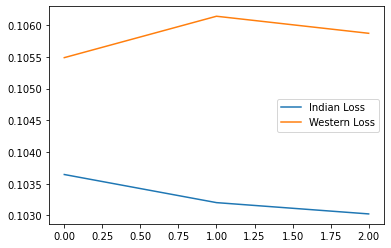

[4,     1] loss: 0.094
[4,     2] loss: 0.094
[4,     3] loss: 0.094
[4,     4] loss: 0.092
[4,     5] loss: 0.095
[4,     6] loss: 0.092
[4,     7] loss: 0.095
[4,     8] loss: 0.092
[4,     9] loss: 0.093
[4,    10] loss: 0.095
[4,    11] loss: 0.096
[4,    12] loss: 0.093
[4,    13] loss: 0.092
[4,    14] loss: 0.092
[4,    15] loss: 0.094
[4,    16] loss: 0.094
[4,    17] loss: 0.093
[4,    18] loss: 0.094
[4,    19] loss: 0.094
[4,    20] loss: 0.093
[4,    21] loss: 0.092
[4,    22] loss: 0.093
[4,    23] loss: 0.092
[4,    24] loss: 0.093
[4,    25] loss: 0.091
[4,    26] loss: 0.092
[4,    27] loss: 0.089
[4,    28] loss: 0.090
[4,    29] loss: 0.089
[4,    30] loss: 0.088
[4,    31] loss: 0.099
[4,    32] loss: 0.091
[4,    33] loss: 0.096
[4,    34] loss: 0.090
[4,    35] loss: 0.090
[4,    36] loss: 0.090
[4,    37] loss: 0.094
[4,    38] loss: 0.092
[4,    39] loss: 0.092
[4,    40] loss: 0.092
[4,    41] loss: 0.092
[4,    42] loss: 0.095
[4,    43] loss: 0.096
[4,    44] 

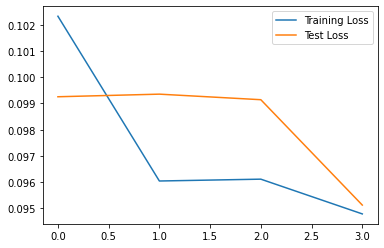

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 3 is 0.10024118589030372
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 3 is 0.1000375466214286


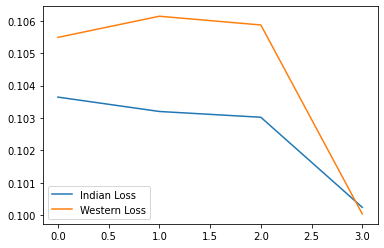

[5,     1] loss: 0.090
[5,     2] loss: 0.091
[5,     3] loss: 0.093
[5,     4] loss: 0.091
[5,     5] loss: 0.092
[5,     6] loss: 0.088
[5,     7] loss: 0.091
[5,     8] loss: 0.089
[5,     9] loss: 0.090
[5,    10] loss: 0.089
[5,    11] loss: 0.088
[5,    12] loss: 0.088
[5,    13] loss: 0.088
[5,    14] loss: 0.087
[5,    15] loss: 0.087
[5,    16] loss: 0.089
[5,    17] loss: 0.086
[5,    18] loss: 0.088
[5,    19] loss: 0.088
[5,    20] loss: 0.087
[5,    21] loss: 0.088
[5,    22] loss: 0.087
[5,    23] loss: 0.087
[5,    24] loss: 0.085
[5,    25] loss: 0.085
[5,    26] loss: 0.087
[5,    27] loss: 0.086
[5,    28] loss: 0.087
[5,    29] loss: 0.087
[5,    30] loss: 0.086
[5,    31] loss: 0.087
[5,    32] loss: 0.085
[5,    33] loss: 0.087
[5,    34] loss: 0.086
[5,    35] loss: 0.087
[5,    36] loss: 0.086
[5,    37] loss: 0.087
[5,    38] loss: 0.086
[5,    39] loss: 0.084
[5,    40] loss: 0.087
[5,    41] loss: 0.087
[5,    42] loss: 0.086
[5,    43] loss: 0.088
[5,    44] 

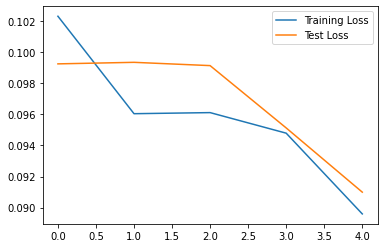

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 4 is 0.09715468105342653
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 4 is 0.09439173340797424


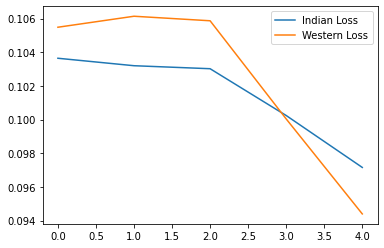

[6,     1] loss: 0.087
[6,     2] loss: 0.086
[6,     3] loss: 0.087
[6,     4] loss: 0.086
[6,     5] loss: 0.087
[6,     6] loss: 0.086
[6,     7] loss: 0.087
[6,     8] loss: 0.085
[6,     9] loss: 0.086
[6,    10] loss: 0.086
[6,    11] loss: 0.086
[6,    12] loss: 0.086
[6,    13] loss: 0.086
[6,    14] loss: 0.085
[6,    15] loss: 0.086
[6,    16] loss: 0.087
[6,    17] loss: 0.084
[6,    18] loss: 0.086
[6,    19] loss: 0.086
[6,    20] loss: 0.085
[6,    21] loss: 0.086
[6,    22] loss: 0.086
[6,    23] loss: 0.084
[6,    24] loss: 0.084
[6,    25] loss: 0.084
[6,    26] loss: 0.085
[6,    27] loss: 0.084
[6,    28] loss: 0.085
[6,    29] loss: 0.086
[6,    30] loss: 0.085
[6,    31] loss: 0.085
[6,    32] loss: 0.084
[6,    33] loss: 0.086
[6,    34] loss: 0.085
[6,    35] loss: 0.085
[6,    36] loss: 0.084
[6,    37] loss: 0.085
[6,    38] loss: 0.084
[6,    39] loss: 0.083
[6,    40] loss: 0.086
[6,    41] loss: 0.085
[6,    42] loss: 0.085
[6,    43] loss: 0.086
[6,    44] 

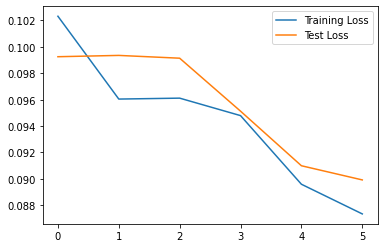

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 5 is 0.09603880594174068
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 5 is 0.0932275073395835


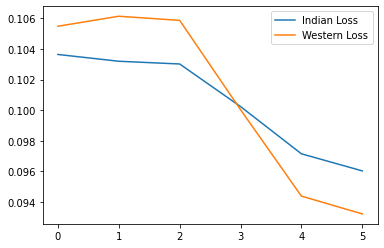

[7,     1] loss: 0.085
[7,     2] loss: 0.084
[7,     3] loss: 0.086
[7,     4] loss: 0.085
[7,     5] loss: 0.086
[7,     6] loss: 0.085
[7,     7] loss: 0.086
[7,     8] loss: 0.084
[7,     9] loss: 0.085
[7,    10] loss: 0.085
[7,    11] loss: 0.084
[7,    12] loss: 0.085
[7,    13] loss: 0.085
[7,    14] loss: 0.083
[7,    15] loss: 0.085
[7,    16] loss: 0.086
[7,    17] loss: 0.083
[7,    18] loss: 0.085
[7,    19] loss: 0.084
[7,    20] loss: 0.084
[7,    21] loss: 0.085
[7,    22] loss: 0.085
[7,    23] loss: 0.083
[7,    24] loss: 0.083
[7,    25] loss: 0.083
[7,    26] loss: 0.084
[7,    27] loss: 0.083
[7,    28] loss: 0.084
[7,    29] loss: 0.084
[7,    30] loss: 0.084
[7,    31] loss: 0.084
[7,    32] loss: 0.083
[7,    33] loss: 0.085
[7,    34] loss: 0.084
[7,    35] loss: 0.084
[7,    36] loss: 0.083
[7,    37] loss: 0.084
[7,    38] loss: 0.083
[7,    39] loss: 0.082
[7,    40] loss: 0.085
[7,    41] loss: 0.084
[7,    42] loss: 0.084
[7,    43] loss: 0.085
[7,    44] 

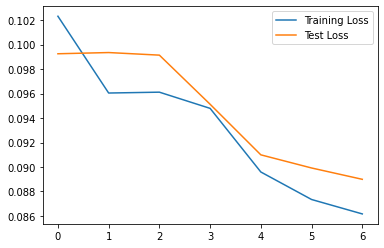

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 6 is 0.09505898588233525
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 6 is 0.09225848399930531


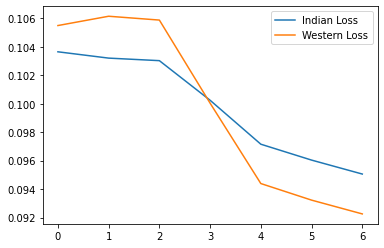

[8,     1] loss: 0.084
[8,     2] loss: 0.083
[8,     3] loss: 0.085
[8,     4] loss: 0.084
[8,     5] loss: 0.085
[8,     6] loss: 0.084
[8,     7] loss: 0.085
[8,     8] loss: 0.083
[8,     9] loss: 0.084
[8,    10] loss: 0.084
[8,    11] loss: 0.084
[8,    12] loss: 0.084
[8,    13] loss: 0.084
[8,    14] loss: 0.083
[8,    15] loss: 0.084
[8,    16] loss: 0.085
[8,    17] loss: 0.082
[8,    18] loss: 0.084
[8,    19] loss: 0.083
[8,    20] loss: 0.083
[8,    21] loss: 0.084
[8,    22] loss: 0.084
[8,    23] loss: 0.082
[8,    24] loss: 0.082
[8,    25] loss: 0.082
[8,    26] loss: 0.083
[8,    27] loss: 0.082
[8,    28] loss: 0.083
[8,    29] loss: 0.083
[8,    30] loss: 0.083
[8,    31] loss: 0.083
[8,    32] loss: 0.082
[8,    33] loss: 0.084
[8,    34] loss: 0.083
[8,    35] loss: 0.083
[8,    36] loss: 0.082
[8,    37] loss: 0.083
[8,    38] loss: 0.082
[8,    39] loss: 0.080
[8,    40] loss: 0.084
[8,    41] loss: 0.083
[8,    42] loss: 0.082
[8,    43] loss: 0.084
[8,    44] 

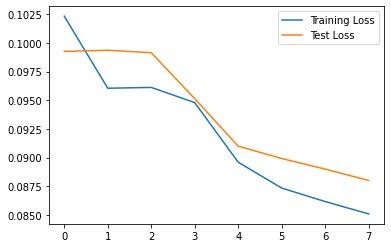

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 7 is 0.09404673675696056
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 7 is 0.09118591083420648


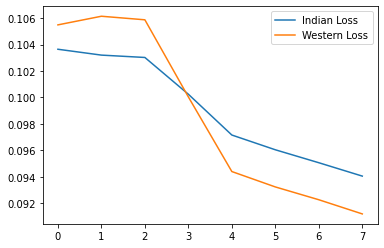

[9,     1] loss: 0.083
[9,     2] loss: 0.082
[9,     3] loss: 0.083
[9,     4] loss: 0.083
[9,     5] loss: 0.084
[9,     6] loss: 0.083
[9,     7] loss: 0.084
[9,     8] loss: 0.082
[9,     9] loss: 0.083
[9,    10] loss: 0.083
[9,    11] loss: 0.083
[9,    12] loss: 0.082
[9,    13] loss: 0.082
[9,    14] loss: 0.081
[9,    15] loss: 0.082
[9,    16] loss: 0.083
[9,    17] loss: 0.081
[9,    18] loss: 0.083
[9,    19] loss: 0.082
[9,    20] loss: 0.081
[9,    21] loss: 0.083
[9,    22] loss: 0.082
[9,    23] loss: 0.080
[9,    24] loss: 0.080
[9,    25] loss: 0.080
[9,    26] loss: 0.081
[9,    27] loss: 0.080
[9,    28] loss: 0.081
[9,    29] loss: 0.080
[9,    30] loss: 0.080
[9,    31] loss: 0.080
[9,    32] loss: 0.078
[9,    33] loss: 0.080
[9,    34] loss: 0.079
[9,    35] loss: 0.080
[9,    36] loss: 0.083
[9,    37] loss: 0.080
[9,    38] loss: 0.078
[9,    39] loss: 0.077
[9,    40] loss: 0.079
[9,    41] loss: 0.080
[9,    42] loss: 0.079
[9,    43] loss: 0.080
[9,    44] 

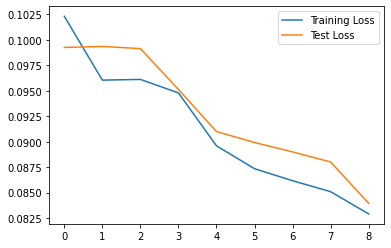

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 8 is 0.09033493283722135
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 8 is 0.08632621003521813


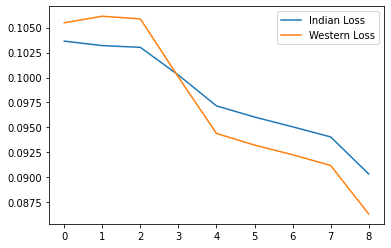

[10,     1] loss: 0.079
[10,     2] loss: 0.078
[10,     3] loss: 0.079
[10,     4] loss: 0.079
[10,     5] loss: 0.080
[10,     6] loss: 0.078
[10,     7] loss: 0.078
[10,     8] loss: 0.077
[10,     9] loss: 0.078
[10,    10] loss: 0.078
[10,    11] loss: 0.078
[10,    12] loss: 0.077
[10,    13] loss: 0.076
[10,    14] loss: 0.076
[10,    15] loss: 0.076
[10,    16] loss: 0.077
[10,    17] loss: 0.074
[10,    18] loss: 0.077
[10,    19] loss: 0.075
[10,    20] loss: 0.075
[10,    21] loss: 0.077
[10,    22] loss: 0.077
[10,    23] loss: 0.074
[10,    24] loss: 0.074
[10,    25] loss: 0.074
[10,    26] loss: 0.075
[10,    27] loss: 0.074
[10,    28] loss: 0.076
[10,    29] loss: 0.075
[10,    30] loss: 0.074
[10,    31] loss: 0.076
[10,    32] loss: 0.073
[10,    33] loss: 0.076
[10,    34] loss: 0.074
[10,    35] loss: 0.073
[10,    36] loss: 0.075
[10,    37] loss: 0.075
[10,    38] loss: 0.073
[10,    39] loss: 0.073
[10,    40] loss: 0.074
[10,    41] loss: 0.074
[10,    42] loss

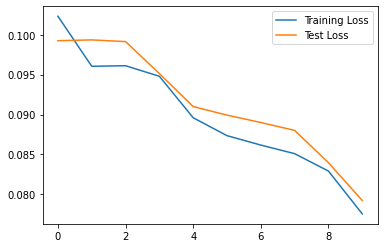

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 9 is 0.08631722463501824
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 9 is 0.08031521903143989


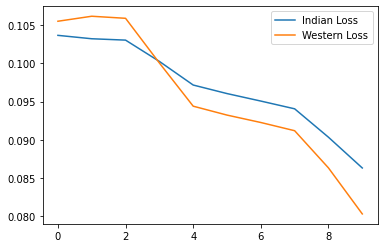

[11,     1] loss: 0.075
[11,     2] loss: 0.073
[11,     3] loss: 0.074
[11,     4] loss: 0.075
[11,     5] loss: 0.076
[11,     6] loss: 0.074
[11,     7] loss: 0.074
[11,     8] loss: 0.074
[11,     9] loss: 0.074
[11,    10] loss: 0.074
[11,    11] loss: 0.074
[11,    12] loss: 0.074
[11,    13] loss: 0.073
[11,    14] loss: 0.073
[11,    15] loss: 0.074
[11,    16] loss: 0.074
[11,    17] loss: 0.071
[11,    18] loss: 0.074
[11,    19] loss: 0.072
[11,    20] loss: 0.073
[11,    21] loss: 0.074
[11,    22] loss: 0.074
[11,    23] loss: 0.071
[11,    24] loss: 0.072
[11,    25] loss: 0.072
[11,    26] loss: 0.072
[11,    27] loss: 0.072
[11,    28] loss: 0.073
[11,    29] loss: 0.072
[11,    30] loss: 0.072
[11,    31] loss: 0.074
[11,    32] loss: 0.071
[11,    33] loss: 0.073
[11,    34] loss: 0.072
[11,    35] loss: 0.071
[11,    36] loss: 0.073
[11,    37] loss: 0.073
[11,    38] loss: 0.071
[11,    39] loss: 0.070
[11,    40] loss: 0.072
[11,    41] loss: 0.072
[11,    42] loss

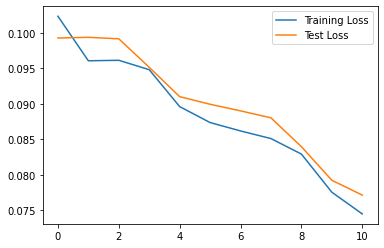

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 10 is 0.08442590882380803
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 10 is 0.07782744533485836


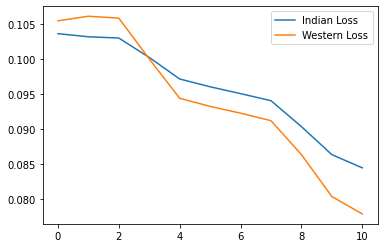

[12,     1] loss: 0.072
[12,     2] loss: 0.071
[12,     3] loss: 0.071
[12,     4] loss: 0.072
[12,     5] loss: 0.074
[12,     6] loss: 0.072
[12,     7] loss: 0.072
[12,     8] loss: 0.072
[12,     9] loss: 0.072
[12,    10] loss: 0.072
[12,    11] loss: 0.072
[12,    12] loss: 0.072
[12,    13] loss: 0.071
[12,    14] loss: 0.071
[12,    15] loss: 0.072
[12,    16] loss: 0.072
[12,    17] loss: 0.069
[12,    18] loss: 0.072
[12,    19] loss: 0.070
[12,    20] loss: 0.071
[12,    21] loss: 0.072
[12,    22] loss: 0.072
[12,    23] loss: 0.069
[12,    24] loss: 0.070
[12,    25] loss: 0.070
[12,    26] loss: 0.070
[12,    27] loss: 0.070
[12,    28] loss: 0.071
[12,    29] loss: 0.070
[12,    30] loss: 0.070
[12,    31] loss: 0.072
[12,    32] loss: 0.069
[12,    33] loss: 0.071
[12,    34] loss: 0.070
[12,    35] loss: 0.069
[12,    36] loss: 0.071
[12,    37] loss: 0.071
[12,    38] loss: 0.069
[12,    39] loss: 0.068
[12,    40] loss: 0.071
[12,    41] loss: 0.070
[12,    42] loss

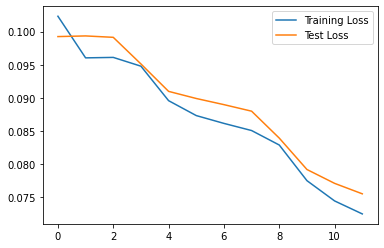

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 11 is 0.08301511324114269
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 11 is 0.0759383953279919


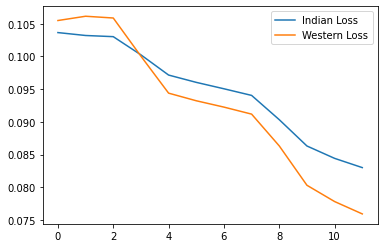

[13,     1] loss: 0.071
[13,     2] loss: 0.069
[13,     3] loss: 0.069
[13,     4] loss: 0.070
[13,     5] loss: 0.072
[13,     6] loss: 0.070
[13,     7] loss: 0.070
[13,     8] loss: 0.070
[13,     9] loss: 0.070
[13,    10] loss: 0.070
[13,    11] loss: 0.071
[13,    12] loss: 0.071
[13,    13] loss: 0.069
[13,    14] loss: 0.070
[13,    15] loss: 0.070
[13,    16] loss: 0.071
[13,    17] loss: 0.067
[13,    18] loss: 0.070
[13,    19] loss: 0.068
[13,    20] loss: 0.069
[13,    21] loss: 0.070
[13,    22] loss: 0.071
[13,    23] loss: 0.067
[13,    24] loss: 0.069
[13,    25] loss: 0.068
[13,    26] loss: 0.069
[13,    27] loss: 0.068
[13,    28] loss: 0.069
[13,    29] loss: 0.069
[13,    30] loss: 0.068
[13,    31] loss: 0.071
[13,    32] loss: 0.067
[13,    33] loss: 0.070
[13,    34] loss: 0.068
[13,    35] loss: 0.068
[13,    36] loss: 0.070
[13,    37] loss: 0.070
[13,    38] loss: 0.068
[13,    39] loss: 0.066
[13,    40] loss: 0.069
[13,    41] loss: 0.068
[13,    42] loss

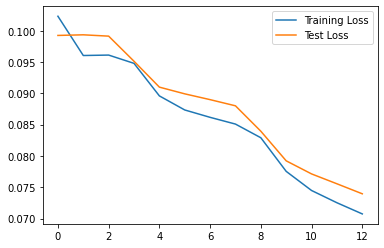

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 12 is 0.0815949754582511
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 12 is 0.07401335156626171


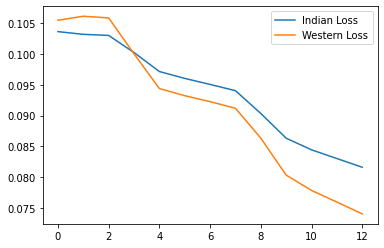

[14,     1] loss: 0.069
[14,     2] loss: 0.067
[14,     3] loss: 0.068
[14,     4] loss: 0.069
[14,     5] loss: 0.070
[14,     6] loss: 0.068
[14,     7] loss: 0.068
[14,     8] loss: 0.069
[14,     9] loss: 0.069
[14,    10] loss: 0.069
[14,    11] loss: 0.069
[14,    12] loss: 0.069
[14,    13] loss: 0.067
[14,    14] loss: 0.068
[14,    15] loss: 0.069
[14,    16] loss: 0.069
[14,    17] loss: 0.065
[14,    18] loss: 0.069
[14,    19] loss: 0.066
[14,    20] loss: 0.068
[14,    21] loss: 0.068
[14,    22] loss: 0.069
[14,    23] loss: 0.065
[14,    24] loss: 0.067
[14,    25] loss: 0.066
[14,    26] loss: 0.067
[14,    27] loss: 0.066
[14,    28] loss: 0.067
[14,    29] loss: 0.066
[14,    30] loss: 0.066
[14,    31] loss: 0.069
[14,    32] loss: 0.065
[14,    33] loss: 0.068
[14,    34] loss: 0.066
[14,    35] loss: 0.066
[14,    36] loss: 0.068
[14,    37] loss: 0.068
[14,    38] loss: 0.066
[14,    39] loss: 0.064
[14,    40] loss: 0.068
[14,    41] loss: 0.066
[14,    42] loss

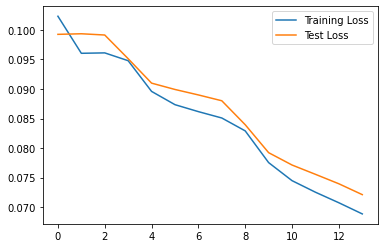

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 13 is 0.07983191808064778
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 13 is 0.07194630636109246


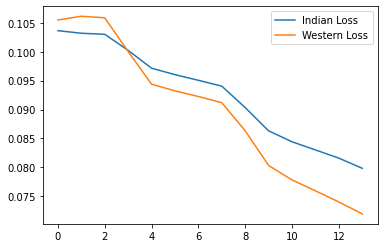

[15,     1] loss: 0.067
[15,     2] loss: 0.065
[15,     3] loss: 0.065
[15,     4] loss: 0.067
[15,     5] loss: 0.068
[15,     6] loss: 0.066
[15,     7] loss: 0.066
[15,     8] loss: 0.066
[15,     9] loss: 0.067
[15,    10] loss: 0.066
[15,    11] loss: 0.068
[15,    12] loss: 0.067
[15,    13] loss: 0.065
[15,    14] loss: 0.066
[15,    15] loss: 0.067
[15,    16] loss: 0.066
[15,    17] loss: 0.064
[15,    18] loss: 0.066
[15,    19] loss: 0.064
[15,    20] loss: 0.066
[15,    21] loss: 0.066
[15,    22] loss: 0.067
[15,    23] loss: 0.063
[15,    24] loss: 0.065
[15,    25] loss: 0.064
[15,    26] loss: 0.065
[15,    27] loss: 0.063
[15,    28] loss: 0.065
[15,    29] loss: 0.064
[15,    30] loss: 0.064
[15,    31] loss: 0.066
[15,    32] loss: 0.063
[15,    33] loss: 0.065
[15,    34] loss: 0.063
[15,    35] loss: 0.063
[15,    36] loss: 0.065
[15,    37] loss: 0.065
[15,    38] loss: 0.063
[15,    39] loss: 0.061
[15,    40] loss: 0.065
[15,    41] loss: 0.063
[15,    42] loss

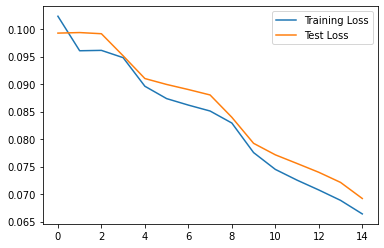

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 14 is 0.07688645356231266
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 14 is 0.06877812122305234


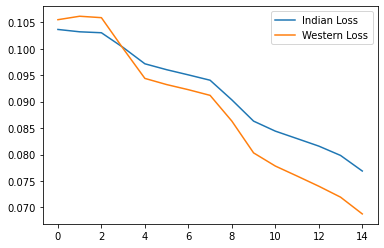

[16,     1] loss: 0.064
[16,     2] loss: 0.062
[16,     3] loss: 0.062
[16,     4] loss: 0.063
[16,     5] loss: 0.066
[16,     6] loss: 0.062
[16,     7] loss: 0.062
[16,     8] loss: 0.063
[16,     9] loss: 0.063
[16,    10] loss: 0.062
[16,    11] loss: 0.064
[16,    12] loss: 0.063
[16,    13] loss: 0.060
[16,    14] loss: 0.062
[16,    15] loss: 0.063
[16,    16] loss: 0.063
[16,    17] loss: 0.060
[16,    18] loss: 0.063
[16,    19] loss: 0.060
[16,    20] loss: 0.062
[16,    21] loss: 0.063
[16,    22] loss: 0.063
[16,    23] loss: 0.059
[16,    24] loss: 0.061
[16,    25] loss: 0.060
[16,    26] loss: 0.061
[16,    27] loss: 0.059
[16,    28] loss: 0.061
[16,    29] loss: 0.059
[16,    30] loss: 0.059
[16,    31] loss: 0.063
[16,    32] loss: 0.059
[16,    33] loss: 0.062
[16,    34] loss: 0.060
[16,    35] loss: 0.059
[16,    36] loss: 0.061
[16,    37] loss: 0.061
[16,    38] loss: 0.059
[16,    39] loss: 0.058
[16,    40] loss: 0.061
[16,    41] loss: 0.059
[16,    42] loss

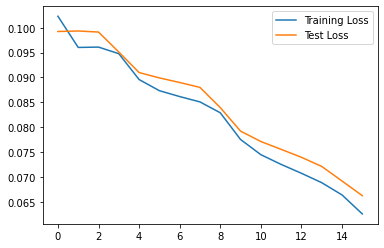

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 15 is 0.07387259519762462
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 15 is 0.0655576383901967


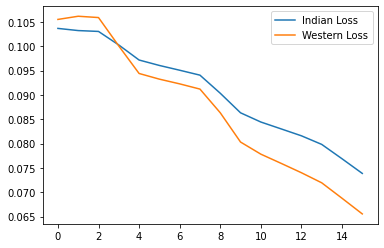

[17,     1] loss: 0.061
[17,     2] loss: 0.059
[17,     3] loss: 0.059
[17,     4] loss: 0.060
[17,     5] loss: 0.062
[17,     6] loss: 0.059
[17,     7] loss: 0.058
[17,     8] loss: 0.059
[17,     9] loss: 0.060
[17,    10] loss: 0.059
[17,    11] loss: 0.061
[17,    12] loss: 0.060
[17,    13] loss: 0.057
[17,    14] loss: 0.059
[17,    15] loss: 0.060
[17,    16] loss: 0.060
[17,    17] loss: 0.057
[17,    18] loss: 0.060
[17,    19] loss: 0.057
[17,    20] loss: 0.058
[17,    21] loss: 0.060
[17,    22] loss: 0.060
[17,    23] loss: 0.056
[17,    24] loss: 0.058
[17,    25] loss: 0.057
[17,    26] loss: 0.058
[17,    27] loss: 0.056
[17,    28] loss: 0.058
[17,    29] loss: 0.057
[17,    30] loss: 0.057
[17,    31] loss: 0.060
[17,    32] loss: 0.057
[17,    33] loss: 0.059
[17,    34] loss: 0.057
[17,    35] loss: 0.056
[17,    36] loss: 0.059
[17,    37] loss: 0.059
[17,    38] loss: 0.056
[17,    39] loss: 0.056
[17,    40] loss: 0.058
[17,    41] loss: 0.057
[17,    42] loss

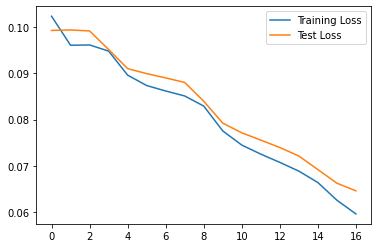

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 16 is 0.07220887806680468
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 16 is 0.06376487347814772


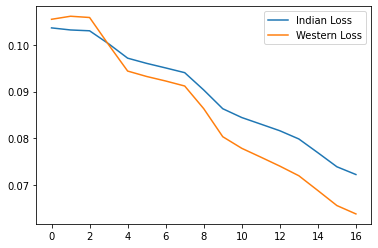

[18,     1] loss: 0.058
[18,     2] loss: 0.056
[18,     3] loss: 0.057
[18,     4] loss: 0.058
[18,     5] loss: 0.060
[18,     6] loss: 0.057
[18,     7] loss: 0.056
[18,     8] loss: 0.057
[18,     9] loss: 0.058
[18,    10] loss: 0.056
[18,    11] loss: 0.058
[18,    12] loss: 0.058
[18,    13] loss: 0.055
[18,    14] loss: 0.057
[18,    15] loss: 0.058
[18,    16] loss: 0.057
[18,    17] loss: 0.055
[18,    18] loss: 0.057
[18,    19] loss: 0.055
[18,    20] loss: 0.056
[18,    21] loss: 0.058
[18,    22] loss: 0.058
[18,    23] loss: 0.054
[18,    24] loss: 0.055
[18,    25] loss: 0.055
[18,    26] loss: 0.055
[18,    27] loss: 0.054
[18,    28] loss: 0.056
[18,    29] loss: 0.054
[18,    30] loss: 0.055
[18,    31] loss: 0.058
[18,    32] loss: 0.055
[18,    33] loss: 0.057
[18,    34] loss: 0.055
[18,    35] loss: 0.054
[18,    36] loss: 0.057
[18,    37] loss: 0.056
[18,    38] loss: 0.054
[18,    39] loss: 0.054
[18,    40] loss: 0.056
[18,    41] loss: 0.055
[18,    42] loss

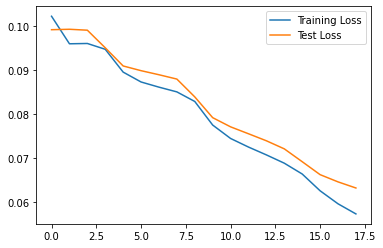

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 17 is 0.07078457416759597
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 17 is 0.06225706016023954


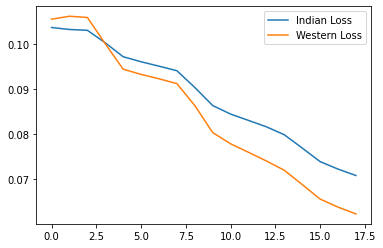

[19,     1] loss: 0.056
[19,     2] loss: 0.054
[19,     3] loss: 0.054
[19,     4] loss: 0.056
[19,     5] loss: 0.058
[19,     6] loss: 0.055
[19,     7] loss: 0.054
[19,     8] loss: 0.054
[19,     9] loss: 0.056
[19,    10] loss: 0.054
[19,    11] loss: 0.056
[19,    12] loss: 0.055
[19,    13] loss: 0.053
[19,    14] loss: 0.054
[19,    15] loss: 0.056
[19,    16] loss: 0.055
[19,    17] loss: 0.053
[19,    18] loss: 0.055
[19,    19] loss: 0.053
[19,    20] loss: 0.054
[19,    21] loss: 0.056
[19,    22] loss: 0.056
[19,    23] loss: 0.052
[19,    24] loss: 0.053
[19,    25] loss: 0.053
[19,    26] loss: 0.053
[19,    27] loss: 0.052
[19,    28] loss: 0.054
[19,    29] loss: 0.052
[19,    30] loss: 0.053
[19,    31] loss: 0.055
[19,    32] loss: 0.052
[19,    33] loss: 0.055
[19,    34] loss: 0.053
[19,    35] loss: 0.052
[19,    36] loss: 0.055
[19,    37] loss: 0.054
[19,    38] loss: 0.052
[19,    39] loss: 0.052
[19,    40] loss: 0.054
[19,    41] loss: 0.052
[19,    42] loss

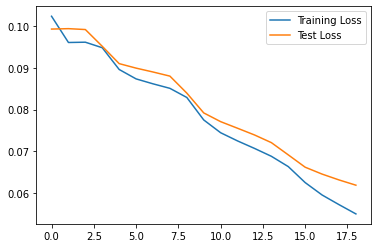

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 18 is 0.06946439834104644
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 18 is 0.060931413951847285


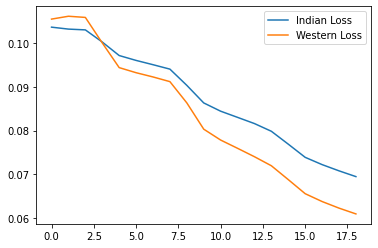

[20,     1] loss: 0.054
[20,     2] loss: 0.052
[20,     3] loss: 0.052
[20,     4] loss: 0.053
[20,     5] loss: 0.055
[20,     6] loss: 0.053
[20,     7] loss: 0.051
[20,     8] loss: 0.052
[20,     9] loss: 0.053
[20,    10] loss: 0.052
[20,    11] loss: 0.054
[20,    12] loss: 0.053
[20,    13] loss: 0.051
[20,    14] loss: 0.052
[20,    15] loss: 0.053
[20,    16] loss: 0.053
[20,    17] loss: 0.051
[20,    18] loss: 0.053
[20,    19] loss: 0.051
[20,    20] loss: 0.052
[20,    21] loss: 0.054
[20,    22] loss: 0.053
[20,    23] loss: 0.049
[20,    24] loss: 0.051
[20,    25] loss: 0.051
[20,    26] loss: 0.051
[20,    27] loss: 0.049
[20,    28] loss: 0.052
[20,    29] loss: 0.050
[20,    30] loss: 0.050
[20,    31] loss: 0.053
[20,    32] loss: 0.050
[20,    33] loss: 0.052
[20,    34] loss: 0.050
[20,    35] loss: 0.050
[20,    36] loss: 0.053
[20,    37] loss: 0.052
[20,    38] loss: 0.049
[20,    39] loss: 0.050
[20,    40] loss: 0.052
[20,    41] loss: 0.050
[20,    42] loss

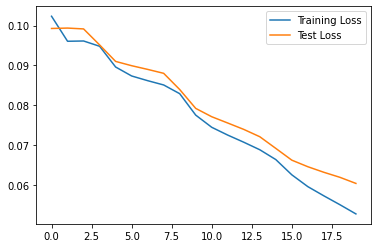

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 19 is 0.06793162433637513
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 19 is 0.05923327058553696


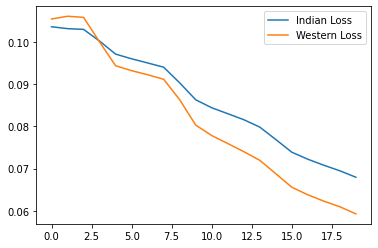

[21,     1] loss: 0.052
[21,     2] loss: 0.049
[21,     3] loss: 0.050
[21,     4] loss: 0.051
[21,     5] loss: 0.053
[21,     6] loss: 0.050
[21,     7] loss: 0.049
[21,     8] loss: 0.050
[21,     9] loss: 0.051
[21,    10] loss: 0.050
[21,    11] loss: 0.051
[21,    12] loss: 0.050
[21,    13] loss: 0.048
[21,    14] loss: 0.050
[21,    15] loss: 0.051
[21,    16] loss: 0.051
[21,    17] loss: 0.049
[21,    18] loss: 0.050
[21,    19] loss: 0.049
[21,    20] loss: 0.049
[21,    21] loss: 0.051
[21,    22] loss: 0.051
[21,    23] loss: 0.047
[21,    24] loss: 0.049
[21,    25] loss: 0.048
[21,    26] loss: 0.048
[21,    27] loss: 0.047
[21,    28] loss: 0.049
[21,    29] loss: 0.047
[21,    30] loss: 0.048
[21,    31] loss: 0.050
[21,    32] loss: 0.048
[21,    33] loss: 0.049
[21,    34] loss: 0.047
[21,    35] loss: 0.048
[21,    36] loss: 0.050
[21,    37] loss: 0.049
[21,    38] loss: 0.047
[21,    39] loss: 0.047
[21,    40] loss: 0.050
[21,    41] loss: 0.048
[21,    42] loss

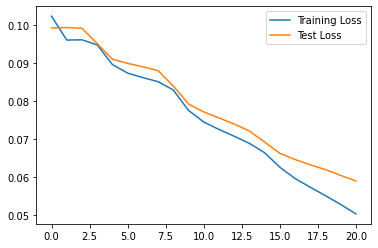

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 20 is 0.0664313216176298
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 20 is 0.057602898942099676


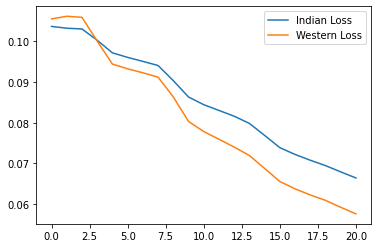

[22,     1] loss: 0.050
[22,     2] loss: 0.047
[22,     3] loss: 0.048
[22,     4] loss: 0.049
[22,     5] loss: 0.050
[22,     6] loss: 0.047
[22,     7] loss: 0.046
[22,     8] loss: 0.047
[22,     9] loss: 0.048
[22,    10] loss: 0.047
[22,    11] loss: 0.049
[22,    12] loss: 0.047
[22,    13] loss: 0.046
[22,    14] loss: 0.047
[22,    15] loss: 0.048
[22,    16] loss: 0.048
[22,    17] loss: 0.046
[22,    18] loss: 0.047
[22,    19] loss: 0.046
[22,    20] loss: 0.047
[22,    21] loss: 0.049
[22,    22] loss: 0.048
[22,    23] loss: 0.045
[22,    24] loss: 0.046
[22,    25] loss: 0.046
[22,    26] loss: 0.046
[22,    27] loss: 0.045
[22,    28] loss: 0.047
[22,    29] loss: 0.045
[22,    30] loss: 0.046
[22,    31] loss: 0.048
[22,    32] loss: 0.045
[22,    33] loss: 0.047
[22,    34] loss: 0.045
[22,    35] loss: 0.045
[22,    36] loss: 0.047
[22,    37] loss: 0.047
[22,    38] loss: 0.044
[22,    39] loss: 0.045
[22,    40] loss: 0.047
[22,    41] loss: 0.045
[22,    42] loss

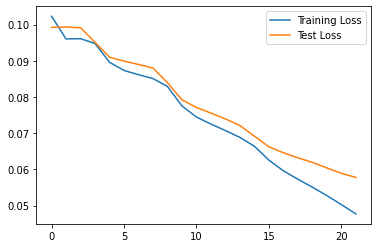

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 21 is 0.06529865082767275
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 21 is 0.05633308531509505


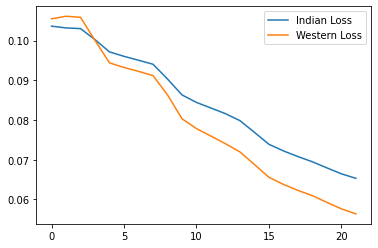

[23,     1] loss: 0.047
[23,     2] loss: 0.044
[23,     3] loss: 0.045
[23,     4] loss: 0.046
[23,     5] loss: 0.048
[23,     6] loss: 0.045
[23,     7] loss: 0.044
[23,     8] loss: 0.045
[23,     9] loss: 0.047
[23,    10] loss: 0.045
[23,    11] loss: 0.047
[23,    12] loss: 0.046
[23,    13] loss: 0.044
[23,    14] loss: 0.046
[23,    15] loss: 0.047
[23,    16] loss: 0.046
[23,    17] loss: 0.045
[23,    18] loss: 0.046
[23,    19] loss: 0.044
[23,    20] loss: 0.045
[23,    21] loss: 0.047
[23,    22] loss: 0.046
[23,    23] loss: 0.043
[23,    24] loss: 0.044
[23,    25] loss: 0.044
[23,    26] loss: 0.043
[23,    27] loss: 0.042
[23,    28] loss: 0.044
[23,    29] loss: 0.043
[23,    30] loss: 0.043
[23,    31] loss: 0.045
[23,    32] loss: 0.043
[23,    33] loss: 0.045
[23,    34] loss: 0.042
[23,    35] loss: 0.043
[23,    36] loss: 0.045
[23,    37] loss: 0.044
[23,    38] loss: 0.042
[23,    39] loss: 0.043
[23,    40] loss: 0.045
[23,    41] loss: 0.043
[23,    42] loss

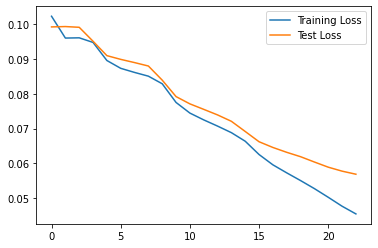

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 22 is 0.06426692547069655
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 22 is 0.055491322030623756


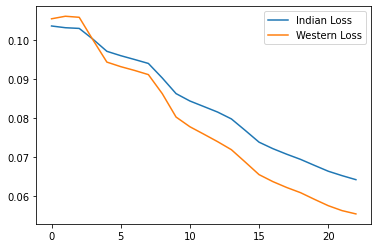

[24,     1] loss: 0.045
[24,     2] loss: 0.042
[24,     3] loss: 0.043
[24,     4] loss: 0.044
[24,     5] loss: 0.046
[24,     6] loss: 0.043
[24,     7] loss: 0.042
[24,     8] loss: 0.043
[24,     9] loss: 0.044
[24,    10] loss: 0.043
[24,    11] loss: 0.044
[24,    12] loss: 0.043
[24,    13] loss: 0.042
[24,    14] loss: 0.043
[24,    15] loss: 0.044
[24,    16] loss: 0.043
[24,    17] loss: 0.042
[24,    18] loss: 0.043
[24,    19] loss: 0.042
[24,    20] loss: 0.043
[24,    21] loss: 0.045
[24,    22] loss: 0.044
[24,    23] loss: 0.041
[24,    24] loss: 0.042
[24,    25] loss: 0.042
[24,    26] loss: 0.042
[24,    27] loss: 0.040
[24,    28] loss: 0.043
[24,    29] loss: 0.041
[24,    30] loss: 0.041
[24,    31] loss: 0.043
[24,    32] loss: 0.041
[24,    33] loss: 0.043
[24,    34] loss: 0.040
[24,    35] loss: 0.041
[24,    36] loss: 0.043
[24,    37] loss: 0.042
[24,    38] loss: 0.040
[24,    39] loss: 0.040
[24,    40] loss: 0.042
[24,    41] loss: 0.041
[24,    42] loss

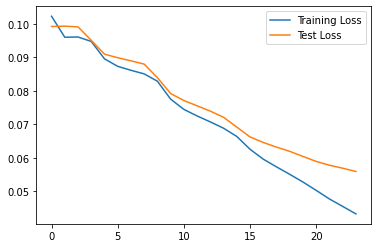

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 23 is 0.06315026639236344
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 23 is 0.054566635853714414


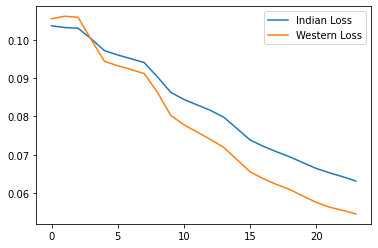

[25,     1] loss: 0.042
[25,     2] loss: 0.040
[25,     3] loss: 0.041
[25,     4] loss: 0.041
[25,     5] loss: 0.043
[25,     6] loss: 0.041
[25,     7] loss: 0.040
[25,     8] loss: 0.040
[25,     9] loss: 0.042
[25,    10] loss: 0.041
[25,    11] loss: 0.042
[25,    12] loss: 0.041
[25,    13] loss: 0.040
[25,    14] loss: 0.041
[25,    15] loss: 0.042
[25,    16] loss: 0.041
[25,    17] loss: 0.040
[25,    18] loss: 0.041
[25,    19] loss: 0.040
[25,    20] loss: 0.041
[25,    21] loss: 0.042
[25,    22] loss: 0.041
[25,    23] loss: 0.039
[25,    24] loss: 0.040
[25,    25] loss: 0.040
[25,    26] loss: 0.039
[25,    27] loss: 0.038
[25,    28] loss: 0.040
[25,    29] loss: 0.038
[25,    30] loss: 0.039
[25,    31] loss: 0.041
[25,    32] loss: 0.039
[25,    33] loss: 0.040
[25,    34] loss: 0.038
[25,    35] loss: 0.039
[25,    36] loss: 0.040
[25,    37] loss: 0.040
[25,    38] loss: 0.038
[25,    39] loss: 0.039
[25,    40] loss: 0.040
[25,    41] loss: 0.039
[25,    42] loss

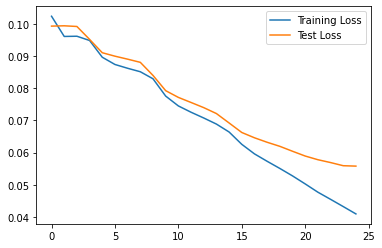

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 24 is 0.06283068574137157
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 24 is 0.05463220799962679


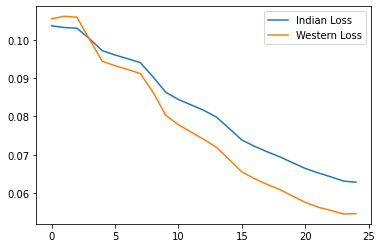

[26,     1] loss: 0.040
[26,     2] loss: 0.038
[26,     3] loss: 0.039
[26,     4] loss: 0.040
[26,     5] loss: 0.040
[26,     6] loss: 0.039
[26,     7] loss: 0.038
[26,     8] loss: 0.038
[26,     9] loss: 0.039
[26,    10] loss: 0.038
[26,    11] loss: 0.040
[26,    12] loss: 0.038
[26,    13] loss: 0.037
[26,    14] loss: 0.038
[26,    15] loss: 0.039
[26,    16] loss: 0.038
[26,    17] loss: 0.038
[26,    18] loss: 0.038
[26,    19] loss: 0.037
[26,    20] loss: 0.039
[26,    21] loss: 0.040
[26,    22] loss: 0.039
[26,    23] loss: 0.037
[26,    24] loss: 0.037
[26,    25] loss: 0.038
[26,    26] loss: 0.038
[26,    27] loss: 0.036
[26,    28] loss: 0.038
[26,    29] loss: 0.037
[26,    30] loss: 0.037
[26,    31] loss: 0.038
[26,    32] loss: 0.037
[26,    33] loss: 0.038
[26,    34] loss: 0.036
[26,    35] loss: 0.037
[26,    36] loss: 0.038
[26,    37] loss: 0.038
[26,    38] loss: 0.036
[26,    39] loss: 0.037
[26,    40] loss: 0.038
[26,    41] loss: 0.036
[26,    42] loss

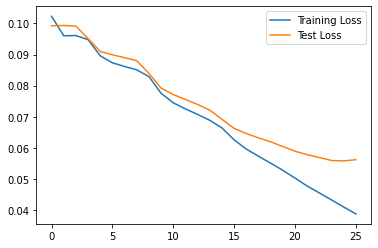

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 25 is 0.06316788867115974
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 25 is 0.055153673307763204


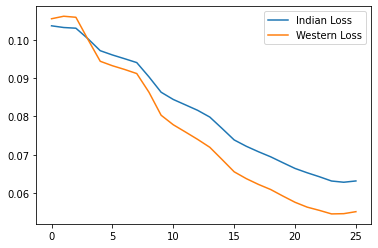

[27,     1] loss: 0.037
[27,     2] loss: 0.035
[27,     3] loss: 0.037
[27,     4] loss: 0.038
[27,     5] loss: 0.038
[27,     6] loss: 0.036
[27,     7] loss: 0.035
[27,     8] loss: 0.036
[27,     9] loss: 0.037
[27,    10] loss: 0.036
[27,    11] loss: 0.038
[27,    12] loss: 0.036
[27,    13] loss: 0.036
[27,    14] loss: 0.037
[27,    15] loss: 0.037
[27,    16] loss: 0.036
[27,    17] loss: 0.036
[27,    18] loss: 0.036
[27,    19] loss: 0.036
[27,    20] loss: 0.037
[27,    21] loss: 0.037
[27,    22] loss: 0.037
[27,    23] loss: 0.035
[27,    24] loss: 0.036
[27,    25] loss: 0.035
[27,    26] loss: 0.035
[27,    27] loss: 0.034
[27,    28] loss: 0.035
[27,    29] loss: 0.034
[27,    30] loss: 0.036
[27,    31] loss: 0.036
[27,    32] loss: 0.035
[27,    33] loss: 0.035
[27,    34] loss: 0.034
[27,    35] loss: 0.034
[27,    36] loss: 0.036
[27,    37] loss: 0.035
[27,    38] loss: 0.034
[27,    39] loss: 0.034
[27,    40] loss: 0.036
[27,    41] loss: 0.035
[27,    42] loss

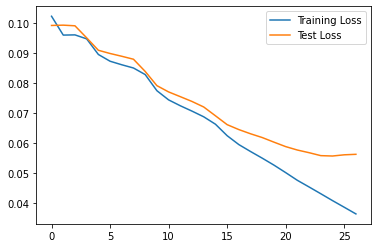

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 26 is 0.0633391539255778
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 26 is 0.05531792218486468


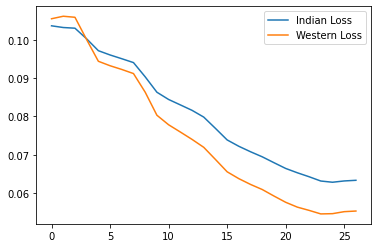

[28,     1] loss: 0.035
[28,     2] loss: 0.033
[28,     3] loss: 0.035
[28,     4] loss: 0.035
[28,     5] loss: 0.036
[28,     6] loss: 0.035
[28,     7] loss: 0.034
[28,     8] loss: 0.034
[28,     9] loss: 0.035
[28,    10] loss: 0.034
[28,    11] loss: 0.035
[28,    12] loss: 0.035
[28,    13] loss: 0.033
[28,    14] loss: 0.034
[28,    15] loss: 0.035
[28,    16] loss: 0.034
[28,    17] loss: 0.034
[28,    18] loss: 0.034
[28,    19] loss: 0.033
[28,    20] loss: 0.034
[28,    21] loss: 0.035
[28,    22] loss: 0.034
[28,    23] loss: 0.032
[28,    24] loss: 0.033
[28,    25] loss: 0.033
[28,    26] loss: 0.033
[28,    27] loss: 0.032
[28,    28] loss: 0.033
[28,    29] loss: 0.033
[28,    30] loss: 0.033
[28,    31] loss: 0.034
[28,    32] loss: 0.033
[28,    33] loss: 0.034
[28,    34] loss: 0.032
[28,    35] loss: 0.033
[28,    36] loss: 0.035
[28,    37] loss: 0.033
[28,    38] loss: 0.032
[28,    39] loss: 0.032
[28,    40] loss: 0.034
[28,    41] loss: 0.033
[28,    42] loss

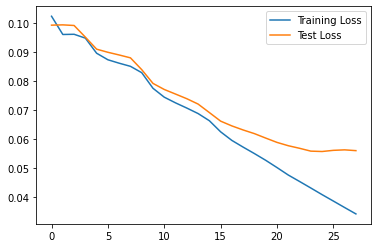

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 27 is 0.0630271149178346
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 27 is 0.0550446862147914


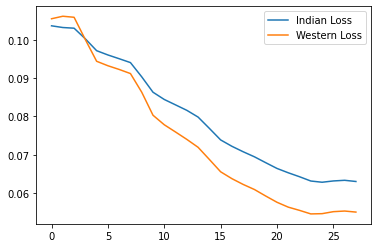

[29,     1] loss: 0.033
[29,     2] loss: 0.031
[29,     3] loss: 0.032
[29,     4] loss: 0.033
[29,     5] loss: 0.034
[29,     6] loss: 0.033
[29,     7] loss: 0.031
[29,     8] loss: 0.033
[29,     9] loss: 0.033
[29,    10] loss: 0.032
[29,    11] loss: 0.034
[29,    12] loss: 0.032
[29,    13] loss: 0.032
[29,    14] loss: 0.033
[29,    15] loss: 0.033
[29,    16] loss: 0.032
[29,    17] loss: 0.033
[29,    18] loss: 0.032
[29,    19] loss: 0.032
[29,    20] loss: 0.032
[29,    21] loss: 0.033
[29,    22] loss: 0.032
[29,    23] loss: 0.030
[29,    24] loss: 0.031
[29,    25] loss: 0.031
[29,    26] loss: 0.030
[29,    27] loss: 0.030
[29,    28] loss: 0.031
[29,    29] loss: 0.030
[29,    30] loss: 0.031
[29,    31] loss: 0.032
[29,    32] loss: 0.030
[29,    33] loss: 0.031
[29,    34] loss: 0.030
[29,    35] loss: 0.030
[29,    36] loss: 0.031
[29,    37] loss: 0.031
[29,    38] loss: 0.031
[29,    39] loss: 0.031
[29,    40] loss: 0.032
[29,    41] loss: 0.031
[29,    42] loss

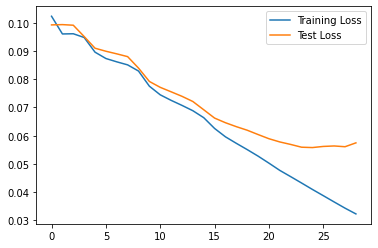

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 28 is 0.06437098276284006
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 28 is 0.056601876185999975


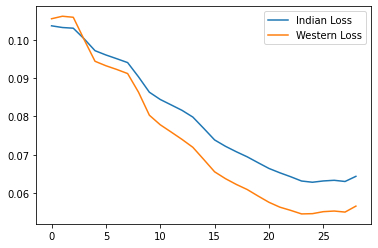

[30,     1] loss: 0.031
[30,     2] loss: 0.030
[30,     3] loss: 0.030
[30,     4] loss: 0.030
[30,     5] loss: 0.031
[30,     6] loss: 0.030
[30,     7] loss: 0.029
[30,     8] loss: 0.031
[30,     9] loss: 0.030
[30,    10] loss: 0.029
[30,    11] loss: 0.031
[30,    12] loss: 0.030
[30,    13] loss: 0.029
[30,    14] loss: 0.029
[30,    15] loss: 0.031
[30,    16] loss: 0.030
[30,    17] loss: 0.029
[30,    18] loss: 0.030
[30,    19] loss: 0.030
[30,    20] loss: 0.030
[30,    21] loss: 0.030
[30,    22] loss: 0.030
[30,    23] loss: 0.029
[30,    24] loss: 0.029
[30,    25] loss: 0.029
[30,    26] loss: 0.029
[30,    27] loss: 0.028
[30,    28] loss: 0.028
[30,    29] loss: 0.029
[30,    30] loss: 0.029
[30,    31] loss: 0.029
[30,    32] loss: 0.029
[30,    33] loss: 0.028
[30,    34] loss: 0.028
[30,    35] loss: 0.028
[30,    36] loss: 0.030
[30,    37] loss: 0.029
[30,    38] loss: 0.028
[30,    39] loss: 0.028
[30,    40] loss: 0.029
[30,    41] loss: 0.028
[30,    42] loss

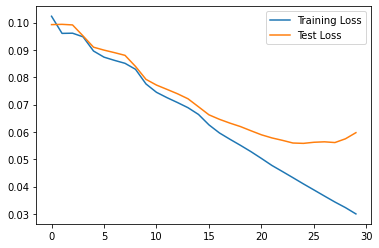

LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 29 is 0.06635996161235704
LOSS of the network on the test images: 0 %
Mean of the network on the train images after epoch 29 is 0.059347053782807455


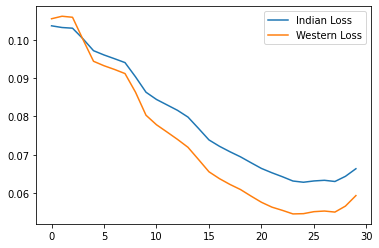

Finished Training


In [35]:
train_loss_graph = []
test_loss_graph = []
best_loss = np.Inf

indian_loss_graph = []
western_loss_graph = []

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    total_Loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_Loss += loss.item()

        if i % print_every == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            running_loss = 0.0
    
    print('LOSS of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    if reduction_loss == "mean":
      total_Loss = total_Loss/i
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    
    train_loss_graph.append(total_Loss)
    correct = 0
    total = 0
    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(testloader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    
    test_loss_graph.append(total_Loss)
    visualize(train_loss_graph, test_loss_graph)
    if total_Loss < best_loss:
      best_loss = total_Loss
      torch.save(net.state_dict(), os.path.join(BASE_PATH, "best_model.pt"))

    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(indian_loader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )

    indian_loss_graph.append(total_Loss)

    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(western_loader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )

    western_loss_graph.append(total_Loss)

    visualize_class_loss(indian_loss_graph, western_loss_graph)
          

print('Finished Training')

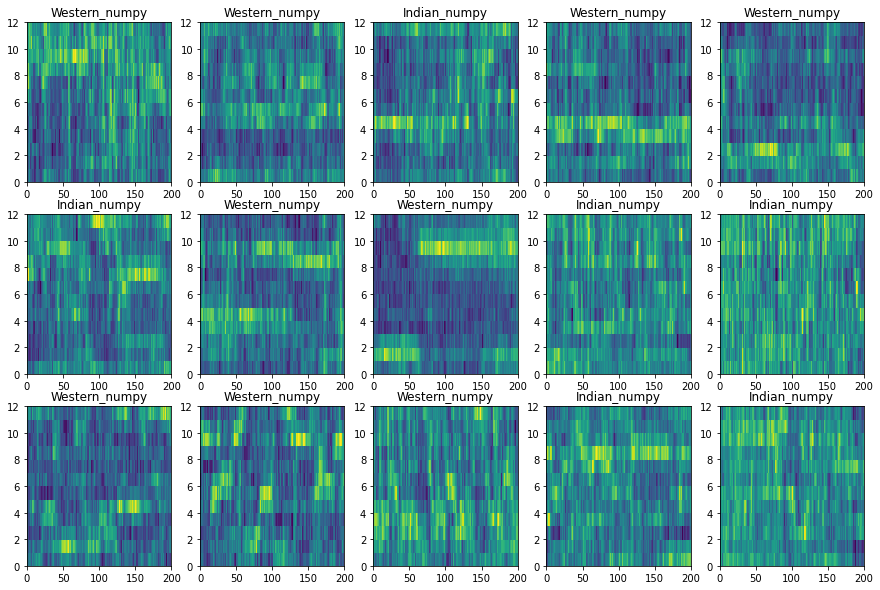

In [36]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        output_img = output_img.squeeze(dim=0)
        ax.pcolormesh(output_img.detach().cpu().permute(1,0)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

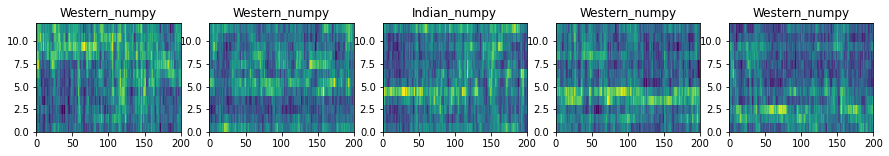

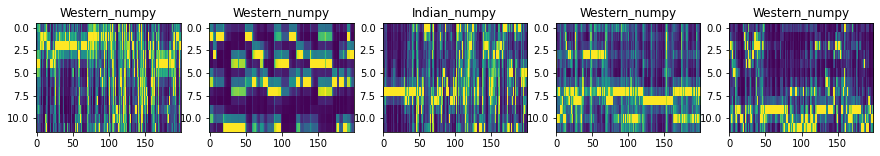

In [37]:
# get some random training images
outputs=[]
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        output_img = output_img.squeeze(dim=0)
        ax.pcolormesh(output_img.detach().cpu().permute(1,0)) # add image
        outputs.append((image.detach().cpu().permute(1,0).flip(0),arthopod_types[label.item()] ))
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for ax , (image, label) in zip(axis.flat, outputs):
    ax.imshow(image, interpolation='nearest', aspect='auto') # add image
    ax.set(title = f"{label}") # add label
    
        

In [38]:
torch.save(net.state_dict(), os.path.join(BASE_PATH, "final_model.pt"))

Start evaluation - Test model

In [39]:
model = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
model.load_state_dict(torch.load(os.path.join(BASE_PATH, "best_model.pt"), map_location=device))

<All keys matched successfully>

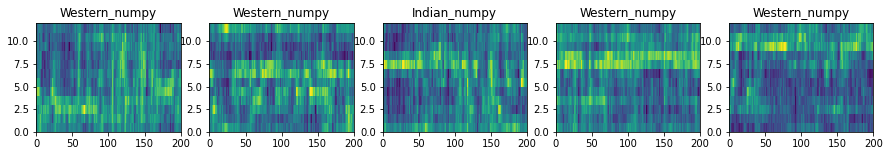

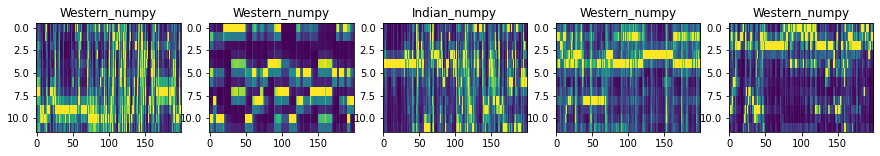

In [40]:
# get some random training images
outputs=[]
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = model(image.unsqueeze(dim=0))
        output_img = output_img.squeeze(dim=0)
        ax.pcolormesh(output_img.detach().cpu().permute(1,0).flip(0)) # add image
        outputs.append((image.detach().cpu().permute(1,0),arthopod_types[label.item()] ))
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for ax , (image, label) in zip(axis.flat, outputs):
    ax.imshow(image, interpolation='nearest', aspect='auto') # add image
    ax.set(title = f"{label}") # add label

Combined data set recinstruction

In [ ]:
combined_dataset = MEL_Dataset(dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
combinedloader = torch.utils.data.DataLoader(combined_dataset, batch_size=batch_size)

In [ ]:
# dataDF
# dataDF.loc[1, 'labels']
# classes
# os.path.join(BASE_PATH, "Activations_64", str(classes[label]))

In [ ]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64",  str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals",  str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

In [ ]:
id = 0
with torch.no_grad():
    for data in combinedloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        
        for  arr64, arr128, arr48, label in zip(output_l2, output_l1, output, labels):
          print(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"))
          np.save(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", classes[label] ,  str(id) + ".npy" ), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", classes[label] ,  str(id) + ".npy"), np.transpose(arr48, (1,0)))
          id = id + 1

Strict data separation

In [34]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "test", str(class_))
  #print("removing ", dir)
  for f in os.listdir(dir):
    #print("removing ", os.path.join(dir, f))
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))


for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

In [41]:
id_test = 0
with torch.no_grad():
    for data_test in testloader:
        inputs, labels, fileNames = data_test
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "test", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "test",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "test",classes[label] ,  str(fileName) ), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "test",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "test",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_test = id_test + 1




/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA/Activations_64/test/Western_numpy/132117.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA/Activations_64/test/Western_numpy/123502.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA/Activations_64/test/Indian_numpy/Dard.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA/Activations_64/test/Western_numpy/042911.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA/Activations_64/test/Western_numpy/076077.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA/Activations_64/test/Indian_numpy/Manguz.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA/Activations_64/test/Western_numpy/053586.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA/Activations_64/test/Western_numpy/128835.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA/Activations_64/test/Indian_numpy/PehliMulakaat.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA/Activations_64/test/Indian_numpy/

In [42]:
id_train = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "training", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "training",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "training",classes[label] ,  str(fileName) ), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "training",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "training",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_train = id_train + 1

/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA/Activations_64/training/Western_numpy/116407.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA/Activations_64/training/Indian_numpy/VilagaadheEnadhuyirae.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA/Activations_64/training/Indian_numpy/VadaladiVarsiRe.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA/Activations_64/training/Indian_numpy/AthmavinAkashathil.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA/Activations_64/training/Indian_numpy/MayaNadhi.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA/Activations_64/training/Indian_numpy/EkVanzariZulan.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA/Activations_64/training/Western_numpy/096693.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA/Activations_64/training/Indian_numpy/YoureSoBeautiful.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA/Activations_64/training/Indian_numpy/SinglePasanga.np